# Chapter 1: Single cell simulation with current injection (for Project S4)

This example is adapted from the __[BMTK Tutorial 01](https://github.com/AllenInstitute/bmtk/blob/develop/docs/tutorial/01_single_cell_clamped.ipynb)__.

**requirements:**
* Python 2.7, 3.6+
* bmtk
* NEURON 7.4+

## 1. Building the network

First step is to use the bmtk Network Builder to create and save the network. First we instantiate a network with a name or our choosing (since we will use the downloaded cell model from the mouse that the donor name is Nr5a1-Cre;Ai14(IVSCC)-177334, let's call our network 'Nr5a1-Cre'). 

Once we have a network, we can add a single node by calling the add_nodes method.

In [ ]:
from bmtk.builder.networks import NetworkBuilder

net = NetworkBuilder('Nr5a1-Cre')
net.add_nodes(cell_name='386049446',
              potental='exc',
              model_type='biophysical',
              model_template='ctdb:Biophys1.hoc',
              model_processing='aibs_perisomatic',
              dynamics_params='386049446_fit.json',
              morphology='Nr5a1-Cre_Ai14-177334.05.01.01_491459171_m.swc')

Some of the parameters used to create the node are optional and only for our benefit. Others are necessary for when we will eventually run a simulation:
* *cell_name* (optional) - Name/type of cell we will be modeling.
* *potential* (optional) - Use to indicate that it is an excitatory type cell.
* *model_type* - Used by the simulator to indicate that we are using a biophysical cell.
* __*dynamics_params*__ - Model parameters. File downloaded from the Allen Cell Types Database. 
* __*morphology*__ - Model morphology. File will downloaded from the Allen Cell Types Database.
* *model_processing* - A custom function used by the simulator to load the model into NEURON using Allen Cell-Types files for perisomatic models ('aibs_allactive' for all_active model).
 
#### Building and saving
The final thing to do is to build and save the network. If successful, we should see a combination of hdf5 and csv files in the './network' directory, these files are used describe the network, and can be saved, stored and run at a later date.

First, it's a good idea to remove any old files in the "network" folder so they don't interfere with the current simulation.

In [ ]:
%%bash
rm network/*

If you get the output:

rm: cannot remove 'network/*': No such file or directory

It's OK. Keep going.

In [ ]:
net.build()
net.save_nodes(output_dir='network')

Use the NetworkBuilder nodes() method to show that a node of our parameters was created

In [ ]:
from pprint import pprint
for node in net.nodes():
    pprint(node)

## 2. Setting up the simulator enviornment

Now that the network has been built, we can use the BioNet simulator to setup and run it using NEURON. We will need to set-up the paths to the configuration and parameters files. We can do this by either:
1. We can build the enviornment by scratch, which we can do from a command-line
```bash
$ python -m bmtk.utils.sim_setup -n network --membrane_report-vars v,cai --membrane_report-sections soma --tstop 2000.0 --dt 0.025 bionet
```
2. Call the function directly in python

In [ ]:
from bmtk.utils.sim_setup import build_env_bionet
build_env_bionet(network_dir='network', tstop=2000.0, dt=0.025,
                 reports={'membrane_report': {
                         "module": "membrane_report",
                         'cells': 'all',
                         'variable_name': ['cai', 'v'],
                         "file_name": "cell_vars.h5",
                         "sections": "soma",
                     }})

This creates standard SONATA configuration files for BioNet, using the built network files in ./network and having a simulation run-time of 2 seconds. The membrane_report-vars and membrane_report-sections sets it so that we are recording membrane potential (v) and calcium concentration (cai) at the soma.:

#### Set the model files
We will need to move the parameters and morphology files into our simulator enviornment:
* Copy *386049446_fit.json*  and place it in ./components/biophysical/electrophysiology/
* Copy *Nr5a1-Cre_Ai14-177334.05.01.01_491459171_m.swc* and place it in ./components/biophysical/morphologies/ 

In [ ]:
%%bash
cp source/386049446_fit.json biophys_components/biophysical_neuron_templates/
cp source/Nr5a1-Cre_Ai14-177334.05.01.01_491459171_m.swc biophys_components/morphologies/

# Checking the simulation_config.json

The file ./simulation_config.json is used to set network, run-time and output parameters during a simulation. In the prefered bmtk workflow the config file is used to update and adjust parameters on different simulations runs, eliminating the need for complicated programs and allows modelers and experimentalist to run their models with little-to-no programming required.

Current what is missing is any input stimulus. Without it the simulation will run, but not do anything interesting. To add a current injection into the soma of our cell, we must open simulation_config.json with a text editor and modify the **input** section to:
```json
"inputs": {
 	"current_clamp": {
      "input_type": "current_clamp",
      "module": "IClamp",
      "node_set": "all",
      "amp": 0.180,
      "delay": 500.0,
      "duration": 1000.0
    }
},
```

This will inject a current (amp) of 0.18 nA with a delay of 500 ms and a duration of 1000 ms (i.e from times 500 - 1500 ms).

Open 386049446_fit.json and find the **condition** section and copy the content. Paste it to the **condition** section of simulation_config.json like below:
```json
  "conditions": {
    "celsius": 34.0, 
    "erev": [
      {
        "ena": 53.0, 
        "section": "soma", 
        "ek": -107.0
      }
    ], 
    "v_init": -99.73164367675781
  },
```
This will adjust the initial membrane voltage and reversal potentials properly for the cell.

## 3. Running the simulation

Once our config file is setup we can run a simulation either through the command line:
```bash
$ python run_bionet.py simulation_config.json
```

or through the script

In [ ]:
from bmtk.simulator import bionet

conf = bionet.Config.from_json('simulation_config.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

A quick breakdown of the script:
```python
conf = config.from_json('config.json')
io.setup_output_dir(conf)
nrn.load_neuron_modules(conf)
```
This section loads the configuration file, it setups the output directory and files for writing during the simulation, and loads NEURON mechanisms needed by the cell model(s) during the simulation.

```python
net = bionet.BioNetwork.from_config(conf)
```
Creates a NEURON representation of the network, including cell models that have been converted into their NEURON equivelents.

```python
sim = Simulation.from_config(conf, network=net)
sim.run()
```
Sets up and runs the NEURON simulation. When finished the output - spike times, membrane potential and Calcium influx, will be saved into the output directory as specified in the config.



## 4. Analyzing the run

The results of the simulation are placed into various files as specified in the "output" section of the config file. We can change this before run-time if required.

All simulations will save the spike times of the network cells. These are saved in csv format (output/spikes.txt) or hdf5 format(output/spikes.h5). To get the table of spike times for our single-cell network we can run the following method from the analyzer (gid 0 corresponds to our single cell).

In [ ]:
from bmtk.analyzer.spike_trains import to_dataframe
to_dataframe(config_file='simulation_config.json')

When setting up the enviornment and config file we specified cell_vars=['v', 'cai']. This indicates to the simulator to also record membrane potential and calcium diffusion (and we can also specify other variables as long as they are supported in NEURON). The recordings are stored in hdf5 format in the file output/cellvars/0.h5 (0 for the gid of our first and only cell).

In [ ]:
from bmtk.analyzer.cell_vars import plot_report

plot_report(config_file='simulation_config.json')

Following script allows you to get recorded variables. You can further analyze the results if needed.

In [1]:
from bmtk.utils.cell_vars import CellVarsFile
from bmtk.analyzer.cell_vars import _get_cell_report

def get_variable_report(config_file=None, report_file=None, report_name=None, variable=None, gid=None):
    if report_file is None:
        report_name, report_file = _get_cell_report(config_file, report_name)
    var_report = CellVarsFile(report_file)
    time_steps = var_report.time_trace
    return var_report.data(gid=gid, var_name=variable), time_steps

Cai,t = get_variable_report(config_file='simulation_config.json', gid=0, variable="cai")
V,t = get_variable_report(config_file='simulation_config.json', gid=0, variable="v")

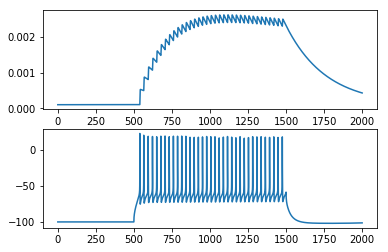

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
plt.subplot(2,1,1)
plt.plot(t,Cai)
plt.subplot(2,1,2)
plt.plot(t,V)
plt.show()

Convert recorded variables into numpy arrays for further data manipulation.

In [ ]:
import numpy as np
t = np.array(t)
V = np.array(V)
Cai= np.array(Cai)

__Notes:__ After analyzing, if you want to change input current and run a new simulation, you have to first edit the *simulation_config.json* file, then go to the notebook menu and do *Kernel->Restart* before you restart simulation in step 3 to avoid an error.